# Фильтрация названий организаций

## Случайный лес + нейронная сеть

### Параметры подобраны вручную (почти по сетке)

Импортируем библиотеки и подключим все написанные заранее функции

In [26]:
%%time
import pickle
import matplotlib.pyplot as plt
from sklearn import ensemble, model_selection, metrics 
import numpy as np
import pandas as pd
from sklearn import model_selection, datasets, linear_model, metrics
import requests
import sys
from bs4 import BeautifulSoup
import time
import re
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

def read_from_file(filename):
    with open(filename,'r') as fb:
        strings =  fb.read().split('\n')
    return strings
def Delete_SQL(string): #Удаляет палочки
    i = string.find('|')
    res = string.partition("|")
    result = res[2]
    if(result.find("|") != -1):
        res = result.partition("|")
        result = res[2]
    return result
def Delete_extended(string): #Удаляет строки из массива delete
    delete = ["RAS", "Russian Academy of Sciences", "of Russian Academy of Sciences", "of the Russian Academy of Sciences", ", Russia", ", RUSSIA", "\n", "}]", ","]
    for part in delete:
        string = string.replace(part, "")
    return string
def Delete_index(string): #Удаляет индекс
    string = re.sub(r'\d{6}','',string)
    return string
def String_format(string): #Удаление всего в правильной последовательности
    string = Delete_SQL(string)
    string = Delete_extended(string)
    string = Delete_index(string)
    return string
def compare(a_str, b_str):
    if a_str == b_str:
        return 1
    num_of_slash = 0
    for i in range(min(len(a_str),len(b_str))):
        if a_str[i] == b_str[i]:
            if a_str[i] == '/':
                num_of_slash +=1
        if a_str[i] != b_str[i]:
            if(num_of_slash >= 3):
                return 0
            else:
                return -1
    if(num_of_slash >= 3):
        return 0
    else:
        return -1    

def Words_comparison(str1, str2):
    if str1.find("/") != -1:
        str1 = str1.replace(".", "/")
        str1 = str1.replace("-", "/")
        str1 = str1.replace("http:", "/")
        str_arr1 = str1.split("/")
        size1 = len(str_arr1)
        for i in range(size1):
            if i < size1 and str_arr1[i] == "":
                str_arr1.remove("")
                i -= 1
                size1 -= 1
        if str_arr1[len(str_arr1) - 1] == "":
            str_arr1.remove("")
    else:
        str_arr1 = str1.split(" ")
        size1 = len(str_arr1)
        for i in range(size1):
            if i < size1 and str_arr1[i] == "":
                str_arr1.remove("")
                i -= 1
                size1 -= 1
        if str_arr1[len(str_arr1) - 1] == "":
            str_arr1.remove("")
    if str2.find("/") != -1:
        str2 = str2.replace(".", "/")
        str2 = str2.replace("-", "/")
        str2 = str2.replace("http:", "/")
        str_arr2 = str2.split("/")
        size2 = len(str_arr2)
        for i in range(size2):
            if i < size2 and str_arr2[i] == "":
                str_arr2.remove("")
                i -= 1
                size2 -= 1
        if str_arr2[len(str_arr2) - 1] == "":
            str_arr2.remove("")
    else:
        str_arr2 = str2.split(" ")
        size2 = len(str_arr2)
        for i in range(size2):
            if i < size2 and str_arr2[i] == "":
                str_arr2.remove("")
                i -= 1
                size2 -= 1
        if str_arr2[len(str_arr2) - 1] == "":
            str_arr2.remove("")
    result = 0
    for i in range(len(str_arr1)):
        for j in range(len(str_arr2)):
            if str_arr1[i].lower() == str_arr2[j].lower():
                result += 1
    return result

def comparation_cikl(etalon,x,N):
    results = np.zeros(2*N + 1)
    results[2*N] = 0
    for i in range(N):
        results[2*i] = 100
        results[2*i + 1] = -1
        for j in range(N):
            res = compare(etalon[i], x[j])
            if res == 1: 
                results[2*i] = j
                results[2*i + 1] = 1
            if res == 0 :
                if results[2*i + 1] != 1:
                    results[2*i] = j
                    results[2*i + 1] = 0
        if etalon[i].find("wikipedia") != -1:
            if results[2*i + 1] != -1:
                if results[2*i + 1] == 1:
                    results[2*N] = 1
                else:
                    if results[2*N] != 1:
                        results[2*N] = -1
    return results

def comparation_cikl_v2(etalon_name, etalon, obj_name, obj, N = 2, max_words = 10):   
    from collections import Counter
    import numpy as np
    compare_matrix = list()
    compare_matrix.append(list(np.zeros((N,N), dtype = int)))
    compare_matrix.append([])
    for i1 in range(N):
        compare_matrix[1].append(list(map(str,list(np.zeros((N), dtype = int)))))
    compare_matrix.append(list())
    compare_matrix.append(list())
    compare_matrix.append(list())
    compare_matrix.append(list())
    for i in range(N):
        for j in range(N):
            compare_matrix[0][i][j] = compare(etalon[i],obj[j])
            if compare_matrix[0][i][j] != -1:
                compare_matrix[1][i][j] = etalon[i].partition('/')[2].partition('/')[2].partition('/')[0] #Оно работает. Это выделение сайта из url
            else: 
                compare_matrix[1][i][j] = ""
        compare_matrix[2].append(Words_comparison(etalon_name, etalon[i]))
        compare_matrix[3].append(Words_comparison(etalon_name, obj[i]))
        compare_matrix[4].append(Words_comparison(obj_name, etalon[i]))
        compare_matrix[5].append(Words_comparison(obj_name, obj[i]))
    result = list()
    for k in range(4):
        if k != 1:
            for i in range(N):
                if k == 0:
                    for j in range (N):
                        result.append(compare_matrix[k][i][j])
                if k > 1:
                    result.append(compare_matrix[k][i])
        else:
            cites = list()
            for i in range(N):
                for j in range(N):
                    if compare_matrix[k][i][j] != "": #Тут k = 1 если что всегда. Стоит k только чтобы всех запутать
                        cites.append(compare_matrix[k][i][j])
            res = Counter(cites).most_common(1)
            if(len(res) != 0):
                result.append(dict(res).get(list(dict(res).keys())[0]))
                wiki = 0
                for i in range(N):
                    for j in range(N):
                        if compare_matrix[k][i][j].find("wikipedia") != -1:
                            if compare_matrix[0][i][j] != -1:
                                if compare_matrix[0][i][j] == 1:
                                    wiki = 1
                                else:
                                    if wiki != 1:
                                        wiki = -1
                result.append(wiki)
            else:
                result.append(0)
                result.append(0)
    return result
def comparation_v3(etalon_name, etalon, obj_name, obj, N = 2, max_words = 10):
    res2 = comparation_cikl_v2(etalon_name, etalon, obj_name, obj, N , max_words )
    res1 = comparation_cikl(etalon,obj,N)
    res = []
    for i in range(len(res1)):
        res.append(res1[i])
    for i in range(len(res2)):
        res.append(res2[i])
    return res
def features_generation_from_ready_urls(raw_file,url_file, N = 5):
    filtred_data1 = list()
    search_results = read_from_file(url_file)
    data = read_from_file(raw_file)

    Etalon_Name = ''
    for i in range(len(data)):
        if data[i].find("||") != -1:
            Etalon_Name = String_format(data[i])
        else:
            if data[i].find("|") != -1:
                label = data[i][:1]
                obj = [label,Etalon_Name, [], String_format(data[i]),[]] #Формат записи данных в объекте:
                filtred_data1.append(obj)#[Метка,Имя_эталона, [сайты эталона],Имя_объекта,[сайты объекта]]
    i = 0
    k = 0
    Etalon_cites = []
    while i<len(search_results):
        if search_results[i] == '':
            i += 1
        else:
            if search_results[i] == 'New Block':
                Etalon_cites = []
                i += 1
            else:
                if Etalon_cites == []:
                    for j in range(N):
                        Etalon_cites.append(search_results[i])
                        i += 1
                else:
                    Obj_cites = []
                    for j in range(N):
                        Obj_cites.append(search_results[i])
                        i += 1
                    if k < len(filtred_data1):
                        filtred_data1[k][2] = Etalon_cites
                        filtred_data1[k][4] = Obj_cites
                        k += 1
                    else:
                        print("Error. Objects in search_results more than in the filtred data1.\n")
                        print("i = ", i, "k = ", k, "len(filtred_data1) = ", len(filtred_data1),"\n")
                        print(Obj_cites)
                        i += 100000
    train_data2 = list()
    train_labels2 = list()
    for i in range(len(filtred_data1)):
        train_labels2.append(filtred_data1[i][0])
        train_data2.append(comparation_cikl(filtred_data1[i][2],filtred_data1[i][4],N))
    return train_data2, train_labels2
def PR_Curve(Classifier, data, labels):
    y = list(map(int,labels))
    y1 = list()
    for i in range(len(data)):
        y1.append(Classifier.predict_proba([data[i]])[0][1])
    precision, recall, thresholds = metrics.precision_recall_curve(y,y1)
    plt.plot( recall, precision)
    print("PR_AUC = ", metrics.auc(recall, precision))
def ROC_Curve(Classifier, data, labels):
    y = list(map(int,labels))
    y1 = list()
    for i in range(len(data)):
        y1.append(Classifier.predict_proba([data[i]])[0][1])
    fpr, tpr, thresholds = metrics.roc_curve(y,y1)
    plt.plot(fpr, tpr)
    print("ROC_AUC = ", metrics.auc(fpr, tpr))
#Код для демонстрационной картиночки. ROC_Curve_2 не нужен, но пусть полежит тут.
#PR_Curve_2 отличается от исходного только выводом recision, recall и thresholds.
def PR_Curve_2(Classifier, data, labels):
    y = list(map(int,labels))
    y1 = list()
    for i in range(len(data)):
        y1.append(Classifier.predict_proba([data[i]])[0][1])
    precision, recall, thresholds = metrics.precision_recall_curve(y,y1)
    plt.plot( recall, precision)
    return precision, recall, thresholds
#def ROC_Curve_2(Classifier, data, labels):
#    y = list(map(int,labels))
#    y1 = list()
#    for i in range(len(data)):
#        y1.append(Classifier.predict_proba([data[i]])[0][1])
#    fpr, tpr, thresholds = metrics.roc_curve(y,y1)
#    return fpr, tpr, thresholds
#User_plot строит линию и полупрозрачный прямоугольник по пороговому значению и ограничениям *_max *_min.
def User_plot(x,y,user_threshold,user_threshold_min,user_threshold_max):
    plt.plot(x,y)
    plt.axvspan(user_threshold_min, user_threshold_max, facecolor='0.5', alpha=0.5)
    plt.axvline(x=user_threshold)
    plt.xlabel('recall')
    plt.ylabel('precision')
#Rec_thresholds_func находит recall соотв. порогам, чтобы по ним потом строить график.
def Rec_thresholds_func(thresholds, recall ,user_threshold,user_threshold_min,user_threshold_max):
    i=len(thresholds)-1
    while thresholds[i]>user_threshold_max:
        i-=1
    rec_threshold_max=recall[i]
    index_max=i
    while thresholds[i]>user_threshold:
        i-=1
    rec_threshold=recall[i]
    while thresholds[i]>user_threshold_min:
        i-=1
    rec_threshold_min=recall[i]
    index_min=i
    return rec_threshold, rec_threshold_min ,rec_threshold_max, index_max, index_min

CPU times: user 128 µs, sys: 13 µs, total: 141 µs
Wall time: 153 µs
Parser   : 158 ms


#### Загрузим данные и метки из каждого файла отдельно

In [3]:
train_data_arr = list(range(4))
train_labels_arr = list(range(4))
k = 0
for i in [0,1,3,5]:
    n1 = str(i)+"v2.txt"
    n2 = "result"+str(i)+".txt"
    train_data_arr[k], train_labels_arr[k] =  features_generation_from_ready_urls(n1,n2,5)
    k += 1

PR_AUC =  0.8731084312648663
PR_AUC =  0.9110532682850527
PR_AUC =  0.778157393597247
PR_AUC =  0.5754893672888346


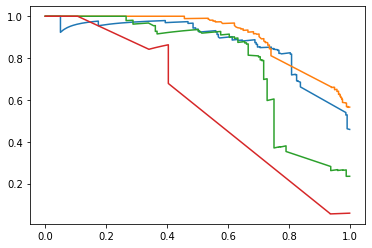

In [4]:
nw = [0,1,3,5]
for i in range(4):
    train_data = list()
    train_labels = list()
    x = list(range(4))
    x.remove(i)
    for j in x:
        for k in range(len(train_data_arr[j])):
            train_data.append(train_data_arr[j][k])
            train_labels.append(train_labels_arr[j][k])
    nw[i] = MLPClassifier(activation='logistic', 
                     hidden_layer_sizes=100,
                     alpha=0.0001,
                     learning_rate_init=0.001,
                     shuffle=False,
                     max_iter=3000)
    nw[i].fit(train_data,train_labels)
    PR_Curve(nw[i], train_data_arr[i], train_labels_arr[i])

ROC_AUC =  0.9018594119484227
ROC_AUC =  0.8578285465622278
ROC_AUC =  0.8342279529741241
ROC_AUC =  0.7546859169199596


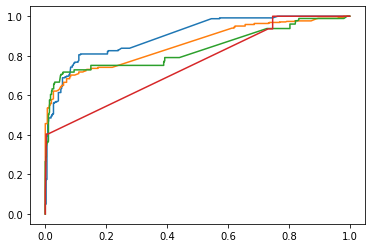

In [5]:
for i in range(4):
    ROC_Curve(nw[i], train_data_arr[i], train_labels_arr[i])

PR_AUC =  0.8863150788068701
PR_AUC =  0.9093303302239613
PR_AUC =  0.7995136641963199
PR_AUC =  0.4701221562688445


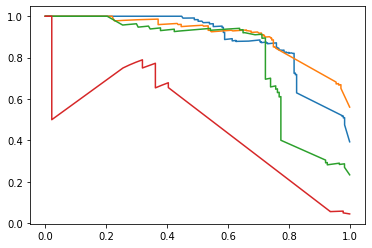

In [6]:
RF = [0,1,3,5]
for i in range(4):
    train_data = list()
    train_labels = list()
    x = list(range(4))
    x.remove(i)
    for j in x:
        for k in range(len(train_data_arr[j])):
            train_data.append(train_data_arr[j][k])
            train_labels.append(train_labels_arr[j][k])
    RF[i] = ensemble.RandomForestClassifier(n_estimators = 400)
    RF[i].fit(train_data,train_labels)
    PR_Curve(RF[i], train_data_arr[i], train_labels_arr[i])

ROC_AUC =  0.8942912595368759
ROC_AUC =  0.8711140121845085
ROC_AUC =  0.8556502037204508
ROC_AUC =  0.7495145221209051


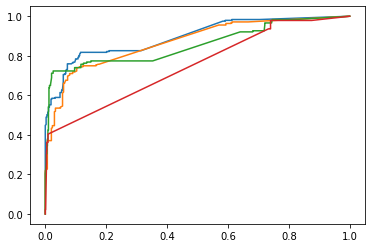

In [7]:
for i in range(4):
    ROC_Curve(RF[i], train_data_arr[i], train_labels_arr[i])

AttributeError: 'AxesSubplot' object has no attribute 'line'

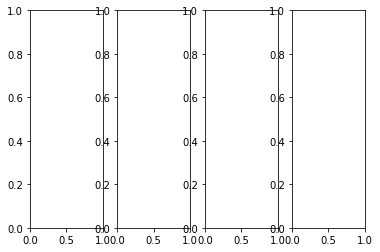

In [8]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 1, ncols = 4)
ax1.line()

In [9]:
for i in range(4):
    print("Accuracy for ", i, "NW", metrics.accuracy_score(train_labels_arr[i],nw[i].predict(train_data_arr[i])))
    print("Accuracy for ", i, "RF", metrics.accuracy_score(train_labels_arr[i],RF[i].predict(train_data_arr[i])))

Accuracy for  0 NW 0.8515497553017944
Accuracy for  0 RF 0.8580750407830342
Accuracy for  1 NW 0.7950219619326501
Accuracy for  1 RF 0.787701317715959
Accuracy for  2 NW 0.8891820580474934
Accuracy for  2 RF 0.9129287598944591
Accuracy for  3 NW 0.9696682464454977
Accuracy for  3 RF 0.9639810426540284


PR_AUC =  0.9209781483209181


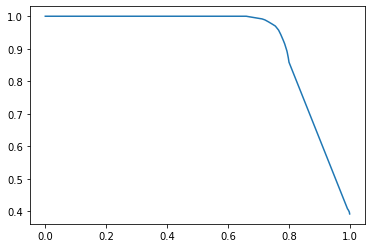

In [10]:
train_data = list()
train_labels = list()
for j in range(4):
    for k in range(len(train_data_arr[j])):
        train_data.append(train_data_arr[j][k])
        train_labels.append(train_labels_arr[j][k])
Tree_ALL = ensemble.RandomForestClassifier(n_estimators = 1,max_features=None,bootstrap = False)
Tree_ALL.fit(train_data,train_labels)
PR_Curve(Tree_ALL, train_data, train_labels)

ROC_AUC =  0.9378716109085143


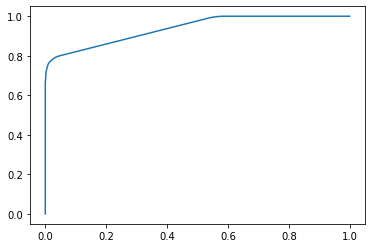

In [11]:
ROC_Curve(Tree_ALL, train_data, train_labels)

PR_AUC =  0.953145169654956


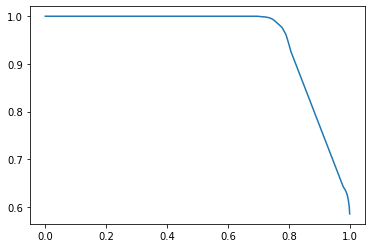

In [12]:
train_data = list()
train_labels = list()
for j in range(3):
    for k in range(len(train_data_arr[j])):
        train_data.append(train_data_arr[j][k])
        train_labels.append(train_labels_arr[j][k])
Tree_no_5 = ensemble.RandomForestClassifier(n_estimators = 1,max_features=None,bootstrap = False)
Tree_no_5.fit(train_data,train_labels)
PR_Curve(Tree_no_5, train_data, train_labels)

ROC_AUC =  0.957529146029554


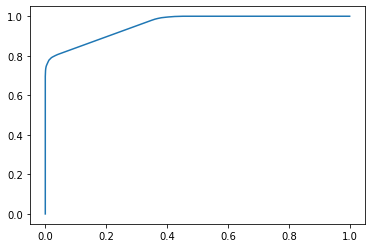

In [13]:
ROC_Curve(Tree_no_5, train_data, train_labels)

PR_AUC =  0.7041313194766886


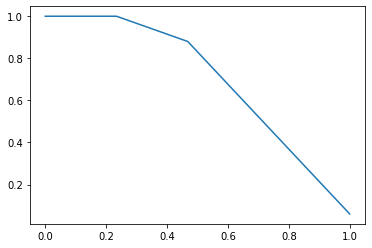

In [14]:
Tree5 = ensemble.RandomForestClassifier(n_estimators = 1,max_features=None,bootstrap = False)
Tree5.fit(train_data_arr[3],train_labels_arr[3])
PR_Curve(Tree5, train_data_arr[3], train_labels_arr[3])

ROC_AUC =  0.8057244174265451


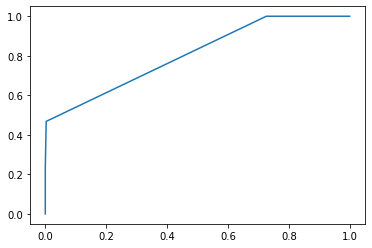

In [15]:
ROC_Curve(Tree5, train_data_arr[3], train_labels_arr[3])

In [16]:
train_data_arr = list(range(8))
train_labels_arr = list(range(8))
k = 0
for i in [0,1,3,4,5,6,7,8]:
    n1 = str(i)+"v2.txt"
    n2 = "result"+str(i)+".txt"
    train_data_arr[k], train_labels_arr[k] =  features_generation_from_ready_urls(n1,n2,5)
    k += 1

FileNotFoundError: [Errno 2] No such file or directory: 'result6.txt'

PR_AUC =  0.8614848812062477
PR_AUC =  0.9078312752804512
PR_AUC =  0.7874131184615591
PR_AUC =  0.8862941858616489
PR_AUC =  0.5203124877996288


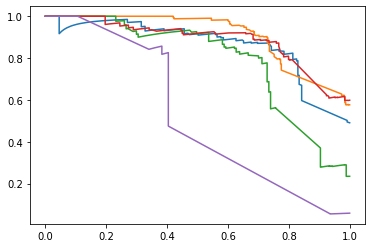

In [17]:
nw2 = [0,1,3,4,5]
for i in range(5):
    train_data = list()
    train_labels = list()
    x = list(range(5))
    x.remove(i)
    for j in x:
        for k in range(len(train_data_arr[j])):
            train_data.append(train_data_arr[j][k])
            train_labels.append(train_labels_arr[j][k])
    nw2[i] = MLPClassifier(activation='logistic', 
                     hidden_layer_sizes=100,
                     alpha=0.0001,
                     learning_rate_init=0.001,
                     shuffle=False,
                     max_iter=3000)
    nw2[i].fit(train_data,train_labels)
    PR_Curve(nw2[i], train_data_arr[i], train_labels_arr[i])

ROC_AUC =  0.889868603042877
ROC_AUC =  0.8509965187119235
ROC_AUC =  0.8651506753405875
ROC_AUC =  0.8541786192388602
ROC_AUC =  0.7483958122255995


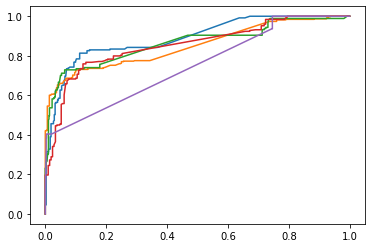

In [18]:
for i in range(5):
    ROC_Curve(nw2[i], train_data_arr[i], train_labels_arr[i])

PR_AUC =  0.8737832424226458
PR_AUC =  0.906824078893686
PR_AUC =  0.8145360213601497
PR_AUC =  0.8955147388916462
PR_AUC =  0.4651515990261564


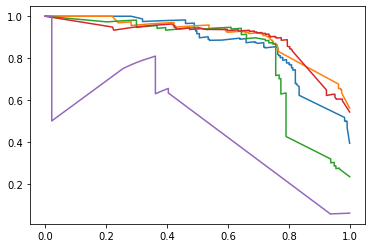

In [19]:
RF2 = [0,1,3,4,5]
for i in range(5):
    train_data = list()
    train_labels = list()
    x = list(range(5))
    x.remove(i)
    for j in x:
        for k in range(len(train_data_arr[j])):
            train_data.append(train_data_arr[j][k])
            train_labels.append(train_labels_arr[j][k])
    RF2[i] = ensemble.RandomForestClassifier(n_estimators = 400)
    RF2[i].fit(train_data,train_labels)
    PR_Curve(RF2[i], train_data_arr[i], train_labels_arr[i])

ROC_AUC =  0.8905434346138401
ROC_AUC =  0.8692993907745865
ROC_AUC =  0.870022462732285
ROC_AUC =  0.8676611206731689
ROC_AUC =  0.7531872678149275


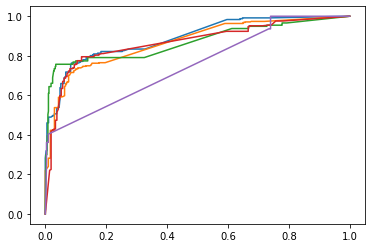

In [20]:
for i in range(5):
    ROC_Curve(RF2[i], train_data_arr[i], train_labels_arr[i])

PR_AUC =  0.8762923365764727
PR_AUC =  0.9027825154934868
PR_AUC =  0.8319290310445346
PR_AUC =  0.8932218796940365
PR_AUC =  0.4709789279197257


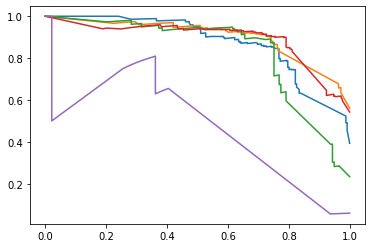

In [21]:
RF2 = [0,1,3,4,5]
for i in range(5):
    train_data = list()
    train_labels = list()
    x = list(range(5))
    x.remove(i)
    for j in x:
        for k in range(len(train_data_arr[j])):
            train_data.append(train_data_arr[j][k])
            train_labels.append(train_labels_arr[j][k])
    RF2[i] = ensemble.RandomForestClassifier(n_estimators = 400, )
    RF2[i].fit(train_data,train_labels)
    PR_Curve(RF2[i], train_data_arr[i], train_labels_arr[i])

In [22]:
?ensemble.RandomForestClassifier

PR_AUC =  0.8827468762286211
PR_AUC =  0.9047289894883601
PR_AUC =  0.8337475757884709
PR_AUC =  0.896872880101817


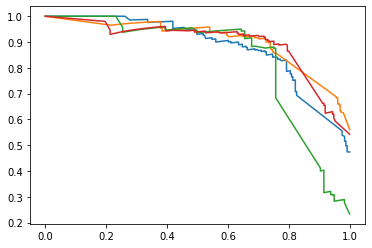

In [23]:
RF = [0,1,3,5]
for i in range(4):
    train_data = list()
    train_labels = list()
    x = list(range(4))
    x.remove(i)
    for j in x:
        for k in range(len(train_data_arr[j])):
            train_data.append(train_data_arr[j][k])
            train_labels.append(train_labels_arr[j][k])
    RF[i] = ensemble.RandomForestClassifier(n_estimators = 400)
    RF[i].fit(train_data,train_labels)
    PR_Curve(RF[i], train_data_arr[i], train_labels_arr[i])

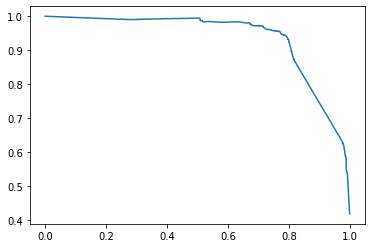

In [24]:
train_data_all=list()
train_labels_all=list()
RF_all=list()
for i in range(4):
    RF_all.append(RF[i])
    for j in range(len(train_data_arr[i])):
        train_data_all.append(train_data_arr[i][j])
        train_labels_all.append(train_labels_arr[i][j])
precision, recall, thresholds=PR_Curve_2(RF[1], train_data_all, train_labels_all)

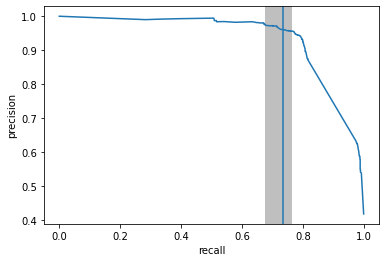

Possible precision: 0.9560047562425684
Possible recall: 0.6752380952380952


In [29]:
user_threshold=0.7
user_threshold_min=0.6
user_threshold_max=0.8
user_threshold, user_threshold_min, user_threshold_max, index_max, index_min = Rec_thresholds_func(thresholds,recall,user_threshold,user_threshold_min,user_threshold_max)
User_plot(recall,precision,user_threshold,user_threshold_min,user_threshold_max)
plt.show()
precision_best=precision[index_min]
recall_best=recall[index_max]
print('Possible precision:',precision_best)
print('Possible recall:', recall_best)